In [1]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  1% |  0% |
|  6 |  1% |  0% |
|  7 |  0% |  0% |


In [2]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time

In [4]:
from arm_preprocessing import generate_word_list, vocab_generator, generate_untyped_encodings
from model import ARM

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

Import Processed Untyped Datasets

In [6]:
biogrid = pd.read_csv('biogrid_norm_rel.csv')
biogrid = biogrid[biogrid.match == 1]
biogrid = biogrid.drop(columns = 'match')
biogrid = biogrid.drop_duplicates(subset = ['source', 'target', 'sentence'])
biogrid = biogrid.dropna()
print('No of sentences with entity mentions:', biogrid.shape[0])
biogrid.head(5)

No of sentences with entity mentions: 306463


,pmid,source,target,interaction,sentence
16,10021333,apt,osk,direct interaction,Given this interaction apt is likely to act t...
17,10021333,apt,osk,direct interaction,Interestingly apt like Bruno is an RNAbinding...
29,10021350,arm,shg,physical association,Drosophila Armadillo and its vertebrate homolo...
30,10021350,arm,shg,physical association,In the current model Wingless Wnt signal stab...
32,10021350,arm,shg,physical association,Overexpression in Xenopus of membranetethered...


In [7]:
chemprot = pd.read_csv('chemprot_norm_rel.csv')
chemprot = chemprot[chemprot.match == 1]
chemprot = chemprot.drop(columns = 'match')
chemprot = chemprot.drop_duplicates(subset = ['source', 'target', 'sentence'])
chemprot = chemprot.dropna()
print('No of sentences with entity mentions:', chemprot.shape[0])
chemprot.head(5)

No of sentences with entity mentions: 15693


,pmid,source,target,interaction,sentence
4,10047461,raltitrexed,egfr,ACTIVATOR,raltitrexed treatment resulted in the decreas...
14,10047461,raltitrexed,egfr,ACTIVATOR,These results suggest that the megabase DNA f...
21,10047461,raltitrexed,cyce,INDIRECT-UPREGULATOR,raltitrexed treatment resulted in the decreas...
27,10047461,raltitrexed,cyce,INDIRECT-UPREGULATOR,The studies with dThyd rescue from cycecdk2 p...
31,10047461,raltitrexed,cyce,INDIRECT-UPREGULATOR,These results suggest that the megabase DNA f...


In [8]:
gad = pd.read_csv('gad_norm_rel.csv')
gad = gad[gad.match == 1]
gad = gad.drop(columns = 'match')
gad = gad.drop_duplicates(subset = ['source', 'target', 'sentence'])
gad = gad.dropna()
print('No of sentences with entity mentions:', gad.shape[0])
gad.head(5)

No of sentences with entity mentions: 18869


,pmid,source,target,sentence
928,10088054,SLC6A3,alcoholism,By applying a familybased association approac...
1104,10097233,AGT,cardiovascular,The significant relations observed between th...
1139,10099886,ACE,Lupus,As angiotensinconverting enzyme ACE is implic...
1157,10099886,ACE,Lupus,These results suggest that the insertion poly...
1288,10195814,GABRA6,alcoholism,Taking into account the high a priori risk of...


Generate vocabulary and sequence of words

In [9]:
biogrid = generate_word_list(biogrid)
chemprot = generate_word_list(chemprot)
gad = generate_word_list(gad)

In [10]:
list_of_words = [item for sublist in list(biogrid.list_of_words)+list(chemprot.list_of_words)+list(gad.list_of_words) for item in sublist]
VOCAB = vocab_generator(list_of_words, lowered = True, VOCAB = {})

VOCAB size = 152170


Text(0.5, 1.0, 'Sentence Length Sensity for GAD')

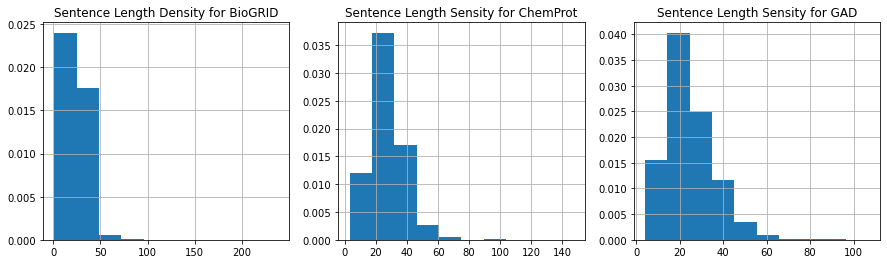

In [11]:
plt.figure(figsize = (15,4))
plt.subplot(131)
biogrid.n_words.hist(density=True)
plt.title('Sentence Length Density for BioGRID')
plt.subplot(132)
chemprot.n_words.hist(density=True)
plt.title('Sentence Length Sensity for ChemProt')
plt.subplot(133)
gad.n_words.hist(density=True)
plt.title('Sentence Length Sensity for GAD')

In [12]:
# Choose maximum length for modeling
maxl = int(max(biogrid.n_words.quantile(q = 0.99), chemprot.n_words.quantile(q = 0.99), gad.n_words.quantile(q = 0.99)) + 1)
print('Maximum sentence length:', maxl)

Maximum sentence length: 60


In [13]:
# Delete entries with sentence length more than maxl
print('No of entries in TRRUST:', biogrid.shape[0])
biogrid = biogrid[biogrid.n_words < maxl]
print('No of entries in BioGRID after dropping sentences having length more than maxl:', biogrid.shape[0])

print('\n')

print('No of entries in AIR:', chemprot.shape[0])
chemprot = chemprot[chemprot.n_words < maxl]
print('No of entries in ChemProt after dropping sentences having length more than maxl:', chemprot.shape[0])

print('\n')

print('No of entries in Elangovan:', gad.shape[0])
gad = gad[gad.n_words < maxl]
print('No of entries in GAD after dropping sentences having length more than maxl:', gad.shape[0])

No of entries in TRRUST: 306463
No of entries in BioGRID after dropping sentences having length more than maxl: 305283


No of entries in AIR: 15693
No of entries in ChemProt after dropping sentences having length more than maxl: 15542


No of entries in Elangovan: 18869
No of entries in GAD after dropping sentences having length more than maxl: 18685


Generate Untyped Encodings and Tokens

In [14]:
biogrid_int_df = generate_untyped_encodings(biogrid, maxl, VOCAB)
chemprot_int_df = generate_untyped_encodings(chemprot, maxl, VOCAB)
gad_int_df = generate_untyped_encodings(gad, maxl, VOCAB)

In [15]:
# Delete entries with no interaction keys or entities
# Delete entries with more than four mentions
biogrid_int_df = biogrid_int_df[(biogrid_int_df.n_source > 0) & (biogrid_int_df.n_source < 5)] 
biogrid_int_df = biogrid_int_df[(biogrid_int_df.n_target > 0) & (biogrid_int_df.n_target < 5)] 

chemprot_int_df = chemprot_int_df[(chemprot_int_df.n_source > 0) & (chemprot_int_df.n_source < 5)] 
chemprot_int_df = chemprot_int_df[(chemprot_int_df.n_target > 0) & (chemprot_int_df.n_target < 5)]

gad_int_df = gad_int_df[(gad_int_df.n_source > 0) & (gad_int_df.n_source < 5)] 
gad_int_df = gad_int_df[(gad_int_df.n_target > 0) & (gad_int_df.n_target < 5)]

Plots for number of entity mentions

Text(0.5, 1.0, 'No of target gene mention')

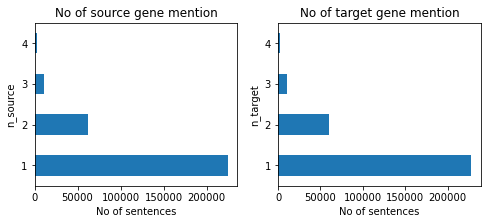

In [16]:
# BioGRID
plt.figure(figsize = (8,3))
plt.subplot(121)
biogrid_int_df.groupby("n_source")['n_source'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of source gene mention')

plt.subplot(122)
biogrid_int_df.groupby("n_target")['n_target'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of target gene mention')

Text(0.5, 1.0, 'No of target gene mention')

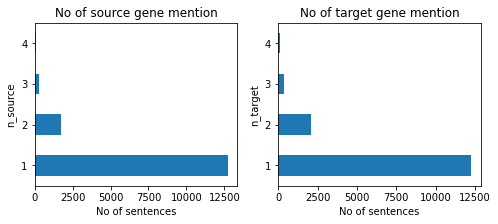

In [17]:
# ChemProt
plt.figure(figsize = (8,3))
plt.subplot(121)
chemprot_int_df.groupby("n_source")['n_source'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of source gene mention')

plt.subplot(122)
chemprot_int_df.groupby("n_target")['n_target'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of target gene mention')

Text(0.5, 1.0, 'No of target gene mention')

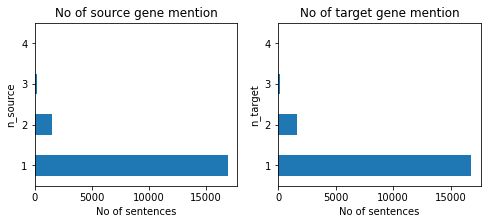

In [18]:
# GAD
plt.figure(figsize = (8,3))
plt.subplot(121)
gad_int_df.groupby("n_source")['n_source'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of source gene mention')

plt.subplot(122)
gad_int_df.groupby("n_target")['n_target'].agg('count').plot.barh()
plt.xlabel('No of sentences');plt.title('No of target gene mention')

272835  Screening for targets of MAGEA11 revealed that it ubiquitinates PCF11 resulting in loss of CFIm25 from the mRNA 3 end processing complex


<AxesSubplot:xlabel='words', ylabel='relative_indexing_source'>

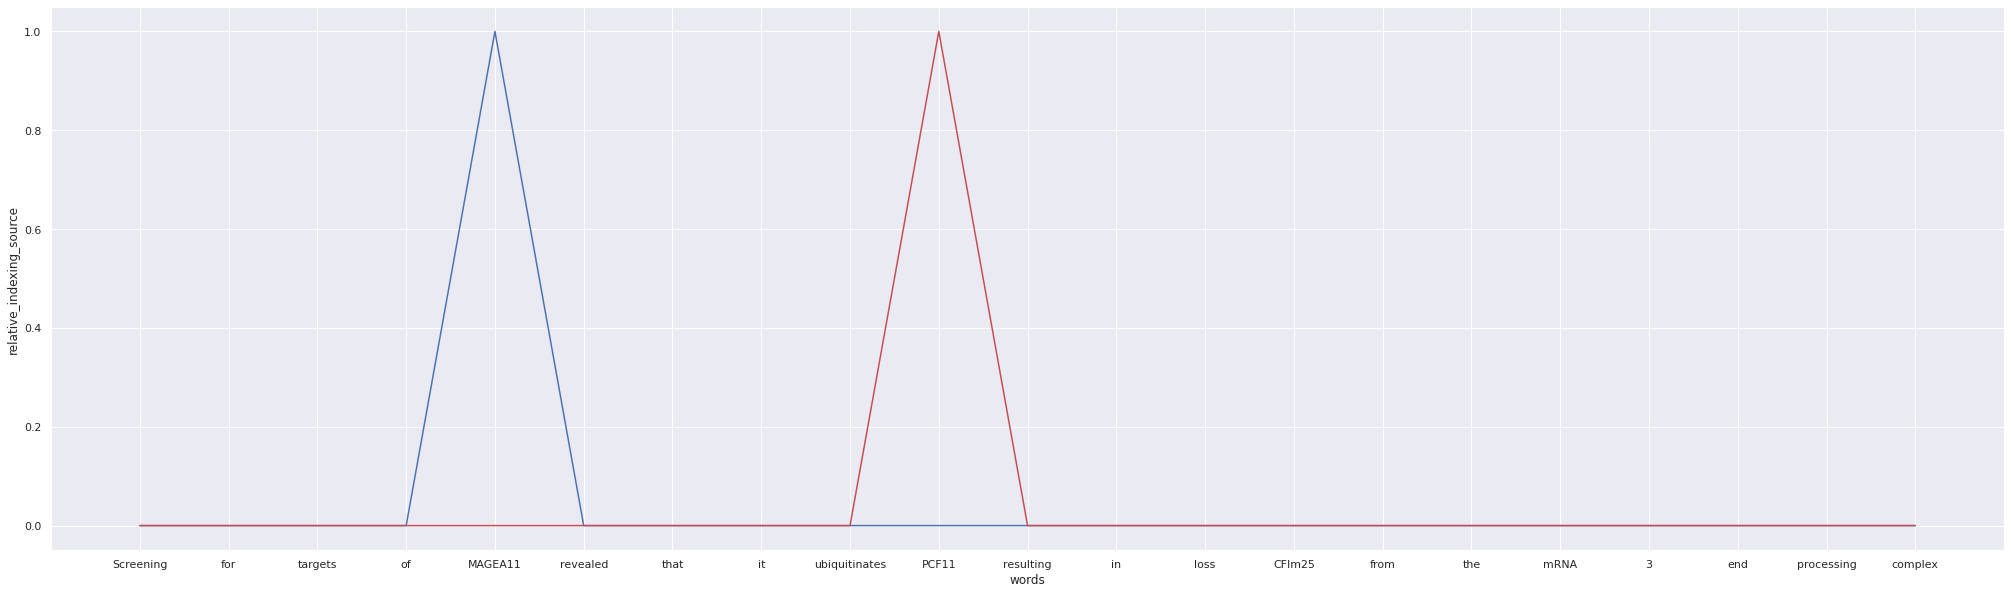

In [19]:
# Encoding Plots
n = np.random.randint(len(biogrid_int_df))
print(n, biogrid_int_df.iloc[n].sentence)
d = {'words':biogrid_int_df.iloc[n].list_of_words,'relative_indexing_source': biogrid_int_df.iloc[n].source_embd[:biogrid_int_df.iloc[n].n_words], \
     'relative_indexing_target': biogrid_int_df.iloc[n].target_embd[:biogrid_int_df.iloc[n].n_words]}
df = pd.DataFrame(d)
sns.set(rc={'figure.figsize':(35,10)})
sns.lineplot(x='words', y='relative_indexing_source', data=df)
sns.lineplot(x='words', y='relative_indexing_target', data=df, color='r')

7339  Here we report that the antifibrotic drug 5methyl1phenyl21Hpyridone pirfenidone PFD elicits growthinhibitory effects and reduces put2 protein levels in human glioma cell lines


<AxesSubplot:xlabel='words', ylabel='relative_indexing_source'>

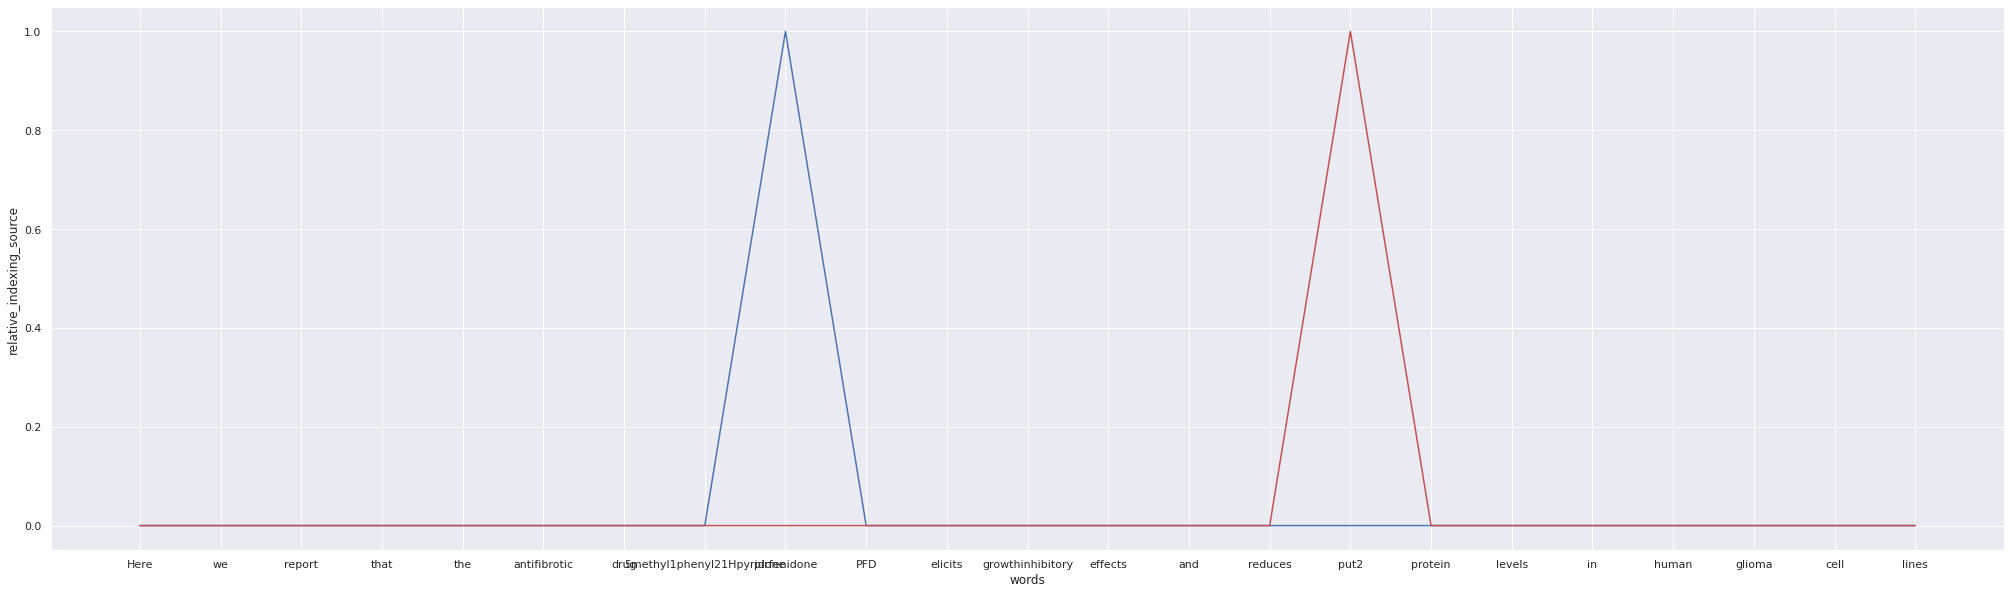

In [20]:
# Encoding Plots
n = np.random.randint(len(chemprot_int_df))
print(n, chemprot_int_df.iloc[n].sentence)
d = {'words':chemprot_int_df.iloc[n].list_of_words,'relative_indexing_source': chemprot_int_df.iloc[n].source_embd[:chemprot_int_df.iloc[n].n_words], \
     'relative_indexing_target': chemprot_int_df.iloc[n].target_embd[:chemprot_int_df.iloc[n].n_words]}
df = pd.DataFrame(d)
sns.set(rc={'figure.figsize':(35,10)})
sns.lineplot(x='words', y='relative_indexing_source', data=df)
sns.lineplot(x='words', y='relative_indexing_target', data=df, color='r')

14353 Influence of genetic polymorphisms smoking gender and age on CYP1A2 activity in a Turkish population


<AxesSubplot:xlabel='words', ylabel='relative_indexing_source'>

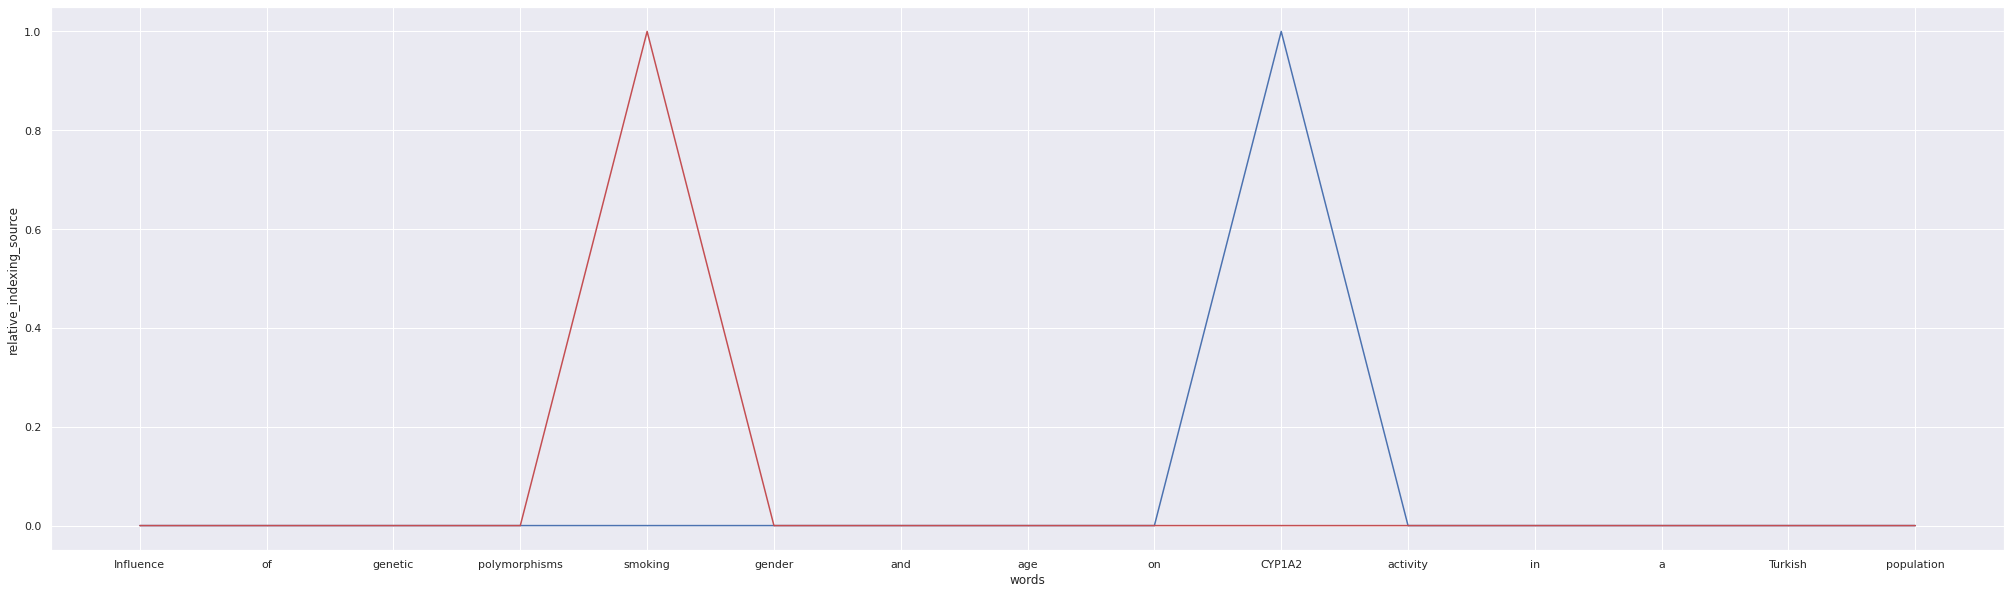

In [21]:
# Encoding Plots
n = np.random.randint(len(gad_int_df))
print(n, gad_int_df.iloc[n].sentence)
d = {'words':gad_int_df.iloc[n].list_of_words,'relative_indexing_source': gad_int_df.iloc[n].source_embd[:gad_int_df.iloc[n].n_words], \
     'relative_indexing_target': gad_int_df.iloc[n].target_embd[:gad_int_df.iloc[n].n_words]}
df = pd.DataFrame(d)
sns.set(rc={'figure.figsize':(35,10)})
sns.lineplot(x='words', y='relative_indexing_source', data=df)
sns.lineplot(x='words', y='relative_indexing_target', data=df, color='r')

In [22]:
print('BioGRID')
print('No of sentences:', biogrid_int_df.shape[0])
print('No of unique entities:', len(set(biogrid_int_df.source.str.lower().to_list() + biogrid_int_df.target.str.lower().to_list())))
print('-'*25)
print('ChemProt')
print('No of sentences:', chemprot_int_df.shape[0])
print('No of unique entities:', len(set(chemprot_int_df.source.str.lower().to_list() + chemprot_int_df.target.str.lower().to_list())))
print('-'*25)
print('GAD')
print('No of sentences:', gad_int_df.shape[0])
print('No of unique entities:', len(set(gad_int_df.source.str.lower().to_list() + gad_int_df.target.str.lower().to_list())))

BioGRID
No of sentences: 301071
No of unique entities: 16373
-------------------------
ChemProt
No of sentences: 14846
No of unique entities: 4320
-------------------------
GAD
No of sentences: 18643
No of unique entities: 2105


In [23]:
# Train df
train_int_df = biogrid_int_df.append(chemprot_int_df).append(gad_int_df).reset_index(drop = True)
print('Curated Dataset: Untyped Interactions')
print('No of sentences:', train_int_df.shape[0])
print('No of unique entities:', len(set(train_int_df.source.str.lower().to_list() + train_int_df.target.str.lower().to_list())))

Curated Dataset: Untyped Interactions
No of sentences: 334560
No of unique entities: 20523


In [24]:
# Shuffle entities
for i in range(len(train_int_df)):
    if np.random.randint(2) == 1:
        t = train_int_df.iloc[i]['target']
        train_int_df.loc[i,'target'] = train_int_df.iloc[i]['source']
        train_int_df.loc[i,'source'] = t        

In [25]:
# 10-Fold
indx = np.arange(len(train_int_df))
fold_test_indxs = []

np.random.seed(10)
for i in range(10):
    f = np.random.choice(indx, int(len(train_int_df)/10), replace=False)
    fold_test_indxs.append(f)
    indx = indx[~np.in1d(indx, f)]

In [26]:
# Model Parameters
snip_len = maxl
embed_dim = 32
num_heads = 8
ff_dim = 32
vocab_size = len(VOCAB) + 1
dropout = 0.1
batch_size = 32

<b> ENT1 > ENT2 </b>

In [27]:
test_eema_1 = []
test_eema_2 = []
test_eema_3 = []

In [28]:
for i in range(10):
    print(f'Fold {i+1}')
    test_indexes = fold_test_indxs[i]
    train_indexes = np.array([x for x in list(range(len(train_int_df))) if x not in test_indexes])
    train_df = train_int_df.iloc[train_indexes].reset_index(drop = True)
    test_df = train_int_df.iloc[test_indexes].reset_index(drop = True)
    print('Train size:', train_df.shape, 'Test size:', test_df.shape)
    
    X_train=tf.convert_to_tensor(np.array([train_df.tokens.tolist(),train_df.source_embd.tolist()]))
    X_test=tf.convert_to_tensor(np.array([test_df.tokens.tolist(),test_df.source_embd.tolist()]))
    y_train=tf.convert_to_tensor(train_df.target_embd.tolist())
    y_test=tf.convert_to_tensor(test_df.target_embd.tolist())
    print('X train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape, 'y_test', y_test.shape)
    
    model = ARM(snip_len, embed_dim, num_heads, ff_dim, dropout, vocab_size)
    model.compile('adam', loss = 'mse')
    
    t0 = time.time()
    history = model.fit([X_train[0],X_train[1]], y_train, batch_size=batch_size, epochs=100, 
                           validation_split=.2, shuffle=True, verbose = 0)
    print('Time taken:', (time.time() - t0)/60)
    # TEST
    print('Test')
    # 1-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-1:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('1-EEMA score:', np.mean(pred_label))
    test_eema_1.append(np.mean(pred_label))
    
    # 2-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-2:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('2-EEMA score:', np.mean(pred_label))
    test_eema_2.append(np.mean(pred_label))
    
    # 3-EEMA score
    y_pred=model.predict([X_test[0],X_test[1]])
    pred_label = []
    sing_pred_label = []
    for i in range(len(y_pred)):
        gene_pos = np.argwhere(y_test[i].numpy() > 0).flatten()
        y_hat = np.argsort(y_pred[i])[-3:]
        p = 0
        for j in y_hat:
            if j in gene_pos:
                p = 1
        pred_label.append(p)
    print('3-EEMA score:', np.mean(pred_label))
    test_eema_3.append(np.mean(pred_label))

Fold 1
Train size: (301104, 15) Test size: (33456, 15)
X train (2, 301104, 60) y_train (301104, 60) X_test (2, 33456, 60) y_test (33456, 60)
Time taken: 191.9653585354487
Test
1-EEMA score: 0.7300932568149211
2-EEMA score: 0.8457675753228121
3-EEMA score: 0.8942491630798661
Fold 2
Train size: (301104, 15) Test size: (33456, 15)
X train (2, 301104, 60) y_train (301104, 60) X_test (2, 33456, 60) y_test (33456, 60)
Time taken: 192.7027401248614
Test
1-EEMA score: 0.7238462458153994
2-EEMA score: 0.8396401243424199
3-EEMA score: 0.8883309421329507
Fold 3
Train size: (301104, 15) Test size: (33456, 15)
X train (2, 301104, 60) y_train (301104, 60) X_test (2, 33456, 60) y_test (33456, 60)
Time taken: 192.206975877285
Test
1-EEMA score: 0.7265662362505978
2-EEMA score: 0.8434959349593496
3-EEMA score: 0.8932329029172644
Fold 4
Train size: (301104, 15) Test size: (33456, 15)
X train (2, 301104, 60) y_train (301104, 60) X_test (2, 33456, 60) y_test (33456, 60)
Time taken: 191.8350502173106
Test


In [29]:
print('TEST')
print('1-EEMA score:', np.mean(test_eema_1))
print('2-EEMA score:', np.mean(test_eema_2))
print('3-EEMA score:', np.mean(test_eema_3))

TEST
1-EEMA score: 0.7256276901004304
2-EEMA score: 0.8443687230989958
3-EEMA score: 0.8933524629363939
